# Lecture 11: Modeling cellular protein allocation at the genome-scale

## Worked example for formulating a proteome-constrained FBA model using minimal data

## 1. Measured growth rates used for validation

In [1]:
import pandas as pd

df_meas = pd.read_csv('data/growth_meas.csv')
df_meas

,substrate,growth_rate_1_h,order,ex_rxn
0,glucose,0.740,0.0,EX_glc__D_e
1,maltose,0.620,3.0,EX_malt_e
2,mannose,0.560,NaN,EX_man_e
3,fructose,0.550,NaN,EX_fru_e
4,galactose,0.520,2.0,EX_gal_e
5,succinate,0.460,NaN,EX_succ_e
6,malate,0.440,NaN,EX_mal__L_e
7,glycerol,0.420,4.0,EX_glyc_e
8,lactate,0.390,1.0,EX_lac__L_e
9,acetate,0.256,5.0,EX_ac_e


---
# Define some convenient simulation and plotting functions

In [2]:
def simulate_media(model, df_meas, growth_id = 'BIOMASS_Ec_iJO1366_core_53p95M', max_uptake=-10, max_ac=-20, max_o2=-20):
    model.reactions.EX_o2_e.lower_bound = max_o2
    rows = []
    for i,row in df_meas.iterrows():
        # Reset uptakes
        for rxn_id in df_meas.ex_rxn:
            rxn = model.reactions.get_by_id(rxn_id)
            rxn.lower_bound = 0
        # Constrain model to this medium
        substrate = row['substrate']
        rid_medium = row['ex_rxn']
        rxn_medium = model.reactions.get_by_id(rid_medium)    
        if substrate=='acetate':
            rxn_medium.lower_bound = max_ac
        else:
            rxn_medium.lower_bound = max_uptake
        # Simulate
        model.optimize(solver='gurobi')
        if model.solution is not None and model.solution.status == 'optimal':
            rxn_growth = model.reactions.get_by_id(growth_id)                    
            rows.append({'substrate':substrate, 'Simulated':rxn_growth.x, 'uptake':rxn_medium.x})
        else:
            rows.append({'substrate':substrate, 'Simulated':0, 'uptake':np.nan})

    df_sim = pd.DataFrame(rows)
    df_val = pd.merge(df_sim, df_meas, on='substrate')
    df_val.loc[:,'Measured'] = df_val.growth_rate_1_h
    
    return df_val

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score

%matplotlib inline

def plot_growth(df_val):
    g = sns.FacetGrid(df_val, size=5, aspect=1)
    g.map(plt.plot, 'Measured','Simulated', linestyle='None', marker='o', zorder=3, markersize=9, markeredgecolor='black', alpha=0.75)
    mumax = max(df_val.Measured.max(), df_val.Simulated.max())*1.05
    n_subs = len(df_val.substrate.unique())        
    for ax in g.axes.flat:
        ax.plot([0,mumax],[0,mumax], color='#333333')
        for k,(i,row) in enumerate(df_val.sort_values('Simulated').iterrows()):
            substrate = row['substrate']
            x = row['Measured']
            y = row['Simulated']
            xx = mumax
            #xx = x+mumax*0.1
            yy = (k)*mumax/n_subs
            ax.plot([x,xx], [y,yy], color='#000000', alpha=0.5)
            ax.text(xx, yy, substrate, ha='left', va='center')
    ### Performance
    r,p = stats.pearsonr(df_val.Measured, df_val.Simulated)
    rho,prho = stats.spearmanr(df_val.Measured, df_val.Simulated)
    r2 = r2_score(df_val.Measured, df_val.Simulated)
    ax.set_title("R^2=%.3g. r=%.3g (p=%.2g)\nrho=%.3g (p=%.2g)" %(r2,r,p,rho,prho))
    
    return g

In [4]:
def plot_ensemble(df_val):
    df_mean = df_val.groupby('substrate')[['Measured','Simulated']].mean().reset_index()
    cmap = 'nipy_spectral'
    g = sns.FacetGrid(df_val, size=5, aspect=1, hue='substrate')
    g.map(plt.plot, 'Measured','Simulated', linestyle='None', marker='.', zorder=3, markersize=6, alpha=0.9) #, markeredgecolor='black')    
    mumax = max(df_val.Measured.max(), df_val.Simulated.max())*1.05
    nSubs = len(df_val.substrate.unique())
    sns.set_palette(cmap, nSubs)
    plt.plot([0,mumax],[0,mumax], color='#333333')    
    n_subs = len(df_val.substrate.unique())        
    
    #pts = plt.scatter('Measured','Simulated', linestyle='None', marker='o', zorder=4, s=64, alpha=0.9, edgecolor='black', data = df_mean, cmap=cmap)
    for ax in g.axes.flat:
        pts = ax.scatter('Measured','Simulated', linestyle='None', marker='o', zorder=4, s=64, alpha=0.9, edgecolor='black', data = df_mean, facecolor='None')
                
        for k,(i,row) in enumerate(df_mean.sort_values('Simulated').iterrows()):
            substrate = row['substrate']
            x = row['Measured']
            y = row['Simulated']
            xx = mumax
            #xx = x+mumax*0.1
            yy = (k)*mumax/n_subs
            ax.plot([x,xx], [y,yy], color='#333333', alpha=0.5, zorder=1)
            ax.text(xx, yy, substrate, ha='left', va='center')

    ### Performance
    r,p = stats.pearsonr(df_val.Measured, df_val.Simulated)
    rho,prho = stats.spearmanr(df_val.Measured, df_val.Simulated)
    r2 = r2_score(df_val.Measured, df_val.Simulated)
    ax.set_title("R^2=%.3g. r=%.3g (p=%.2g)\nrho=%.3g (p=%.2g)" %(r2,r,p,rho,prho))
    return g

## 2. Simulate FBA without protein constraints

In [5]:
from cobra.io import load_json_model

model = load_json_model('data/iJO1366.json')
model.reactions.EX_o2_e.lower_bound = -20
model.optimize()

<Solution 0.98 at 0x7f1ec13fdc50>

In [6]:
df_val = simulate_media(model, df_meas)

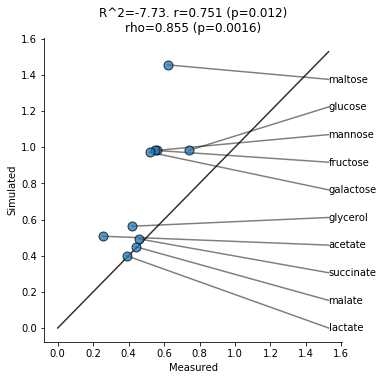

In [7]:
g = plot_growth(df_val)

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

g.savefig('figures/mu_fba.pdf')
g.savefig('figures/mu_fba.svg')
g.savefig('figures/mu_fba.eps')
g.savefig('figures/mu_fba.png',dpi=500)

## 3. Add protein constraints

In [9]:
from cobra import Metabolite, Reaction

class Constraint(Metabolite):
    pass

class Variable(Reaction):
    pass

## Add protein capacity constraint
$$
\begin{align}
\sum_{i\in \mathrm{Cytosolic}} w_i \frac{v_i}{k_i} &\leq P \\
v & \geq 0
\end{align}
$$

$$
\begin{align}
\max_v \quad & c^T v \\
\mathrm{s.t} \quad & S v = 0 \\
& \sum_{i\in \mathrm{Cytosolic}} \frac{mw_i}{k_i} v_i \leq P \\
& l \leq v \leq u \\
& v \geq 0
\end{align}
$$

### Load protein molecular weights

In [10]:
df_mws = pd.read_csv('data/ijomm_protmass_simple_mws_R02.csv')

### Compute total protein mass estimate

In [11]:
print 'Subsystems:', len(df_mws.subsystem.unique())
print 'Rxns within alternate carbon metab:', len(df_mws.rxn[ df_mws.subsystem=='Alternate Carbon Metabolism'])

ProtM = df_mws.mmol_gDW.sum()
ProtGrams = df_mws.g_gDW.sum()
print 'Expressed protein (mmol/gDW):', ProtM
print 'Expressed protein (g/gDW):', ProtGrams

Subsystems: 35
Rxns within alternate carbon metab: 285
Expressed protein (mmol/gDW): 0.004373244734484144
Expressed protein (g/gDW): 0.3105739296612427


### Minimal data requirements:
1. Molecular weight of protein
1. Basal keff estimate

In [12]:
import numpy as np

### Start from fresh M model
pcfba = load_json_model('data/iJO1366.json')

### Define some nominal turnover.
### Assume same for all enzymes for now.
KEFF_SCALE = 0.75
KEFF_BASAL = 65. * KEFF_SCALE

### Add crowding constraint:
cons_crowding = Constraint('crowding')
cons_crowding._constraint_sense = 'L'
cons_crowding._bound = ProtGrams

pcfba.add_metabolites([cons_crowding])

### Track nominal keff dict for sensitivity analysis later
coeff_dict = {}

for rid in df_mws.bigg_id.unique():
    dfi = df_mws[ df_mws.bigg_id==rid]
    keff_nom = dfi['keff_nominal'].mean()
    kDa = dfi['kDa'].mean()
    rxn = pcfba.reactions.get_by_id(rid)    
    keff = KEFF_BASAL
    coeff = 1./keff/3600 * kDa
    ### If rxn is reversible, need to split into positive parts
    ### so that crowding constraint applies to only positive fluxes
    if rxn.lower_bound < 0:
        rxn_abs = Reaction(rxn.id + '_abs')
        pcfba.add_reaction(rxn_abs)
        # rabs >= r  :  rabs - r >= 0
        # rabs >= -r :  rabs + r >= 0        
        cons_abs_p = Constraint('cons_'+rxn.id+'_abs_p')
        cons_abs_n = Constraint('cons_'+rxn.id+'_abs_n')
        cons_abs_p._constraint_sense = 'G'
        cons_abs_n._constraint_sense = 'G'
        rxn_abs.add_metabolites({cons_abs_p: 1., cons_abs_n: 1.})
        rxn.add_metabolites({cons_abs_p:-1., cons_abs_n:1.})        
        rxn_abs.add_metabolites({cons_crowding:coeff })
        coeff_dict[rxn_abs.id] = coeff
    else:
        rxn.add_metabolites({cons_crowding:coeff})
        coeff_dict[rxn.id] = coeff

## 4. Validate protein-constrained FBA

In [13]:
df_pcfba = simulate_media(pcfba, df_meas)

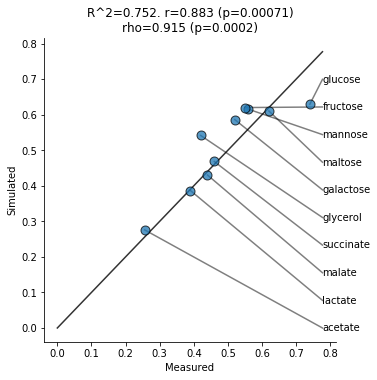

In [14]:
g = plot_growth(df_pcfba)

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

g.savefig('figures/mu_pcfba.pdf')
g.savefig('figures/mu_pcfba.svg')
g.savefig('figures/mu_pcfba.eps')
g.savefig('figures/mu_pcfba.png',dpi=500)

# Do proteome constraints actively limit uptake?
## I.e., can we relax uptake rates, like EX_glc_D_e = -1000
## Will proteome constraint become limiting?

In [16]:
df_uncons = simulate_media(pcfba, df_meas, max_uptake=-1000, max_ac=-1000)

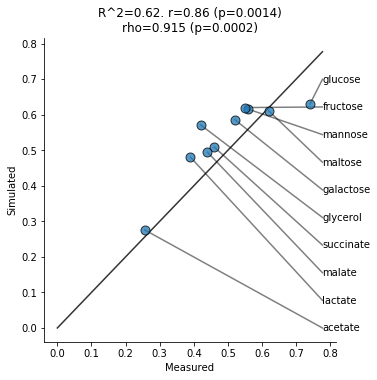

In [17]:
g = plot_growth(df_uncons)

In [18]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

g.savefig('figures/mu_pcfba_freeup.pdf')
g.savefig('figures/mu_pcfba_freeup.svg')
g.savefig('figures/mu_pcfba_freeup.eps')
g.savefig('figures/mu_pcfba_freeup.png',dpi=500)

In [19]:
df_uncons

,Simulated,substrate,uptake,growth_rate_1_h,order,ex_rxn,Measured
0,0.629338,glucose,-9.126119,0.740,0.0,EX_glc__D_e,0.740
1,0.610234,maltose,-4.476351,0.620,3.0,EX_malt_e,0.620
2,0.615289,mannose,-9.023789,0.560,NaN,EX_man_e,0.560
3,0.619943,fructose,-9.089243,0.550,NaN,EX_fru_e,0.550
4,0.586086,galactose,-8.874101,0.520,2.0,EX_gal_e,0.520
5,0.508707,succinate,-20.503596,0.460,NaN,EX_succ_e,0.460
6,0.494403,malate,-19.343429,0.440,NaN,EX_mal__L_e,0.440
7,0.571195,glycerol,-13.994182,0.420,4.0,EX_glyc_e,0.420
8,0.480514,lactate,-19.918585,0.390,1.0,EX_lac__L_e,0.390
9,0.275885,acetate,-12.007728,0.256,5.0,EX_ac_e,0.256


## 5. Sensitivity to coefficients

In [20]:
%%time

N_RAND = 100

import numpy as np

nCrowd = len(pcfba.metabolites.crowding.reactions)
crowding = pcfba.metabolites.crowding
rmin = 0.5
rmax = 2
dfs = []
for _iter in range(N_RAND):
    for rxn in crowding.reactions:
        k0 = coeff_dict[rxn.id]
        r  = np.random.uniform(rmin,rmax)
        rxn._metabolites[crowding] = k0*r

    dfi = simulate_media(pcfba, df_meas, max_uptake=-1000, max_ac=-1000)
    dfi.loc[:,'k'] = _iter
    dfs.append(dfi)
    
df_rand = pd.concat(dfs)

CPU times: user 2min 10s, sys: 160 ms, total: 2min 10s
Wall time: 2min 10s


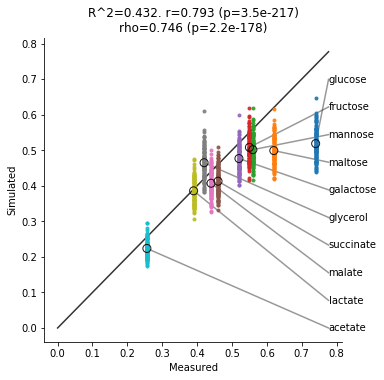

In [21]:
g = plot_ensemble(df_rand)

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

g.savefig('figures/mu_pcfba_freeup_rand.pdf')
g.savefig('figures/mu_pcfba_freeup_rand.svg')
g.savefig('figures/mu_pcfba_freeup_rand.eps')
g.savefig('figures/mu_pcfba_freeup_rand.png', dpi=500)

## 6. Which perturbed coefficients gave the best growth rate?

In [23]:
df_perf = df_rand.groupby('k').apply(lambda x: r2_score(x['Measured'],x['Simulated']))
r2_best = df_perf.max()
kbest = df_perf[ df_perf==r2_best].index[0]
print("Best coefficient of determination = %.3g" % r2_best)

Best coefficient of determination = 0.776


In [24]:
df_best = df_rand[ df_rand.k==kbest]

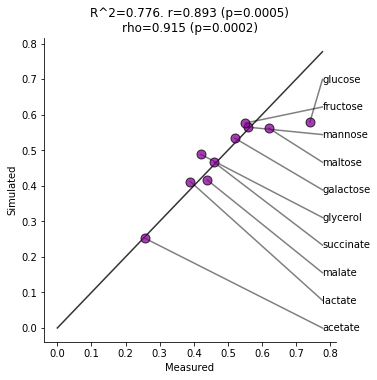

In [25]:
g = plot_growth(df_best)

In [26]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

g.savefig('figures/mu_pcfba_freeup_best.pdf')
g.savefig('figures/mu_pcfba_freeup_best.svg')
g.savefig('figures/mu_pcfba_freeup_best.eps')
g.savefig('figures/mu_pcfba_freeup_best.png', dpi=500)